In [1]:
import tensorflow as tf
from tensorflow import keras
import yaml
import os
import numpy as np
import json
import matplotlib.pyplot as plt



2023-03-28 11:52:16.970099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 11:52:17.077541: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-28 11:52:17.627854: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-28 11:52:17.627913: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [3]:
with open("configs/ml_reconstruction.yaml", "r") as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [4]:
dataset_config = config['dataset']

spec_json_name = [name for name in os.listdir(dataset_config['path']) if '.json' in name][0]
data_spec = json.load(open(os.path.join(dataset_config['path'], spec_json_name)))
h, w, c = data_spec['shape']
data_spec['shape'] = (c, h, w)
dim = data_spec['shape']

dir_x = os.path.join(dataset_config['path'], data_spec['lensless'])
x_filenames = sorted([name for name in os.listdir(dir_x)])

dir_y =  os.path.join(dataset_config['path'], data_spec['lens'])
y_filenames = sorted([name for name in os.listdir(dir_y)])

assert x_filenames == y_filenames, "the lensed filenames must be equal to the lensless filenames"

x_filenames = np.asarray([os.path.join(dir_x, name) for name in x_filenames])
y_filenames = np.asarray([os.path.join(dir_y, name) for name in y_filenames])

num_samples = 5

X = np.empty((num_samples, *dim), dtype=np.float32)
Y = np.empty((num_samples, *dim), dtype=np.float32)

for i, idx in enumerate(range(num_samples)):
    X[i,] = np.load(x_filenames[idx]).transpose(2, 0, 1)#.reshape(dim)
    Y[i,] = np.load(y_filenames[idx]).transpose(2, 0, 1)#.reshape(dim)

In [10]:
path = '/home/jreymond/lensless_ml/stored_models/2023-03-28/u_net.pb'
model = tf.saved_model.load(path)

In [11]:
X_gen = model(tf.convert_to_tensor(X))

ValueError: Could not find matching concrete function to call loaded from the SavedModel. Got:
  Positional arguments (3 total):
    * <tf.Tensor 'inputs:0' shape=(5, 3, 270, 480) dtype=float64>
    * False
    * None
  Keyword arguments: {}

 Expected these arguments to match one of the following 4 option(s):

Option 1:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, 3, 270, 480), dtype=tf.float32, name='input')
    * False
    * None
  Keyword arguments: {}

Option 2:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, 3, 270, 480), dtype=tf.float32, name='inputs')
    * False
    * None
  Keyword arguments: {}

Option 3:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, 3, 270, 480), dtype=tf.float32, name='inputs')
    * True
    * None
  Keyword arguments: {}

Option 4:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, 3, 270, 480), dtype=tf.float32, name='input')
    * True
    * None
  Keyword arguments: {}

In [ ]:
import cv2 as cv

def preplot(image):

    image = np.transpose(image, (1,2,0))
    image_color = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    out_image = np.flipud(np.clip(image_color, 0,1))
    return out_image[60:,62:-38,:]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


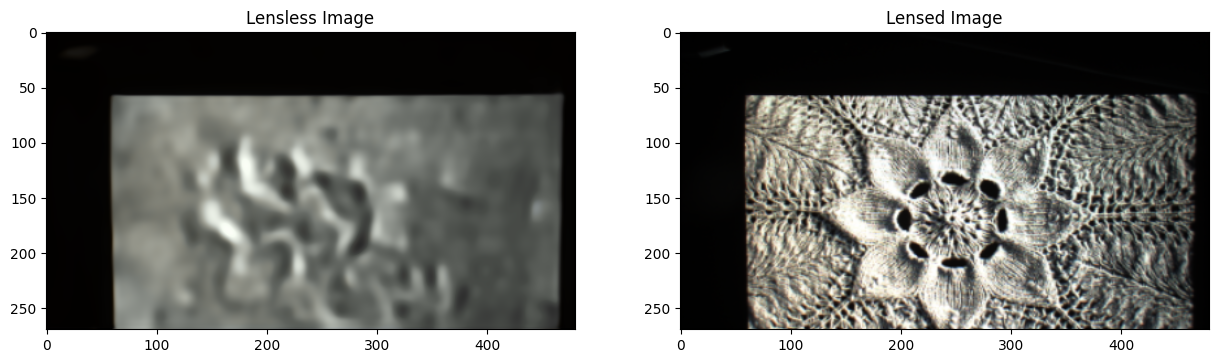

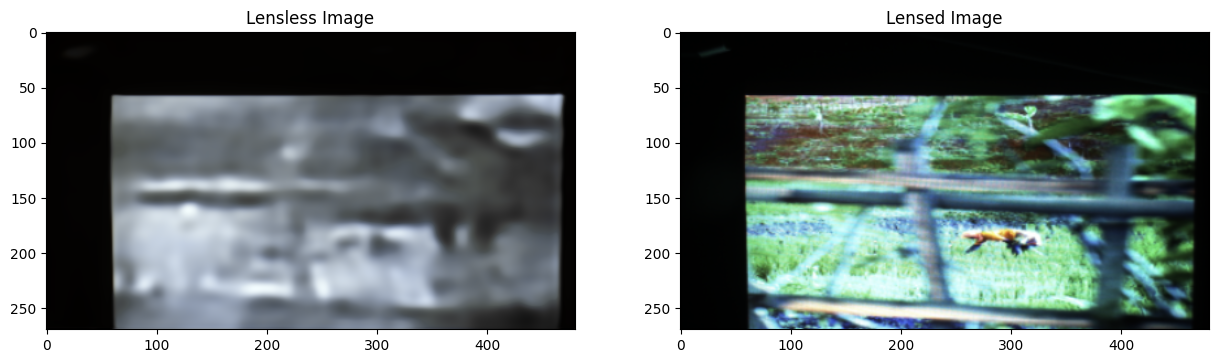

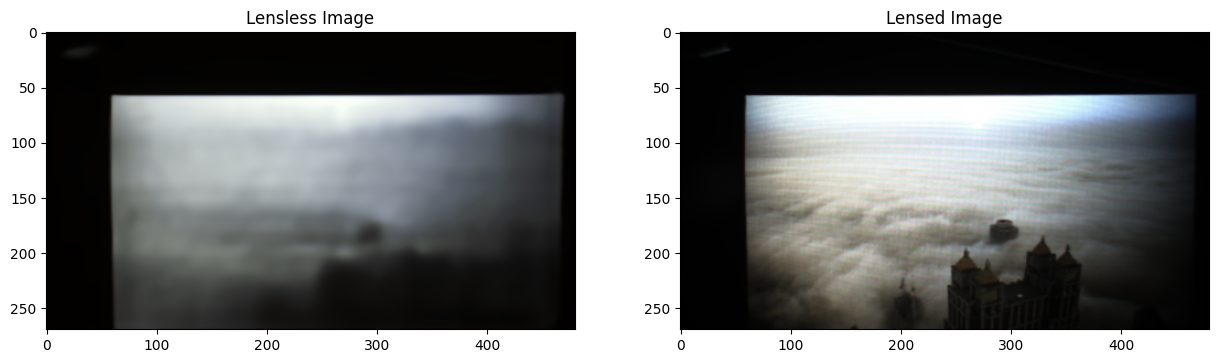

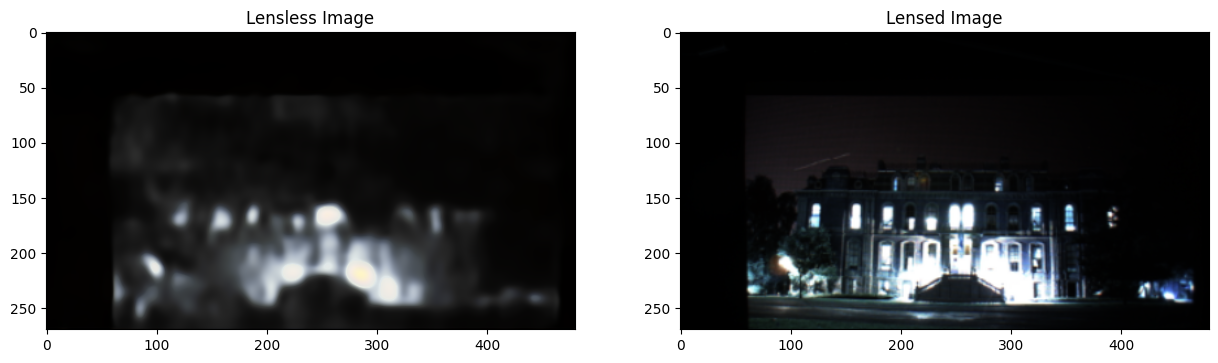

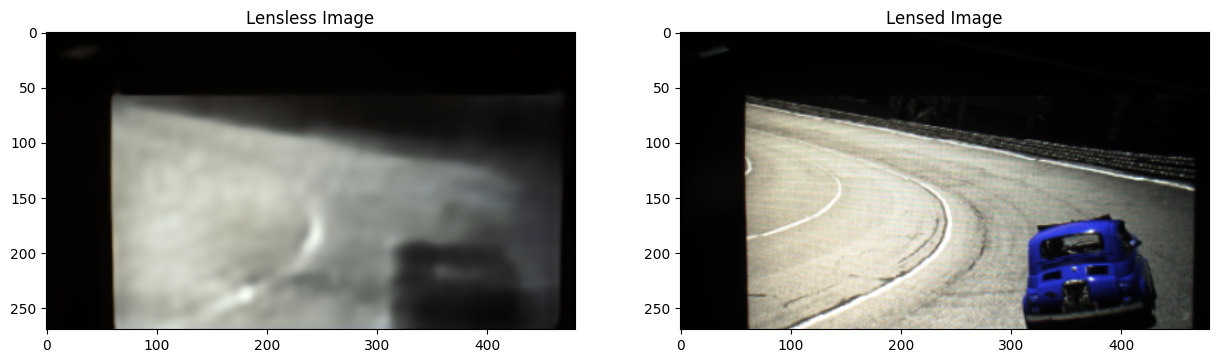

In [ ]:
for i in range(num_samples):

    x_gen = X_gen[i].numpy()
    fig1, ax = plt.subplots(1,2,figsize=(15,5))
    # ax[0].imshow(preplot(x_gen)/ np.max(x_gen)); 
    ax[0].imshow( np.flipud(x_gen.transpose(1, 2, 0))/x_gen.max()); 
    print()
    ax[1].imshow( np.flipud(Y[i].transpose(1, 2, 0))); 
    ax[0].set_title('Lensless Image');  
    ax[1].set_title('Lensed Image');